In [1]:
!pip uninstall tensorflow -y

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0


In [2]:
!pip install tensorflow==2.3.0

     |████████████████████████████████| 320.4 MB 48 kB/s 
     |████████████████████████████████| 20.1 MB 52.1 MB/s 
     |████████████████████████████████| 2.9 MB 34.2 MB/s 
     |████████████████████████████████| 459 kB 43.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviou

In [3]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# preparer la dataset 


importer les packages nécessaire 


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
# Librairies tensorflow
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout,Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import glob
import cv2


 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Images de test et de train 

In [5]:
SIZE = 224  #Resize images
savedModel = 'cnn_vgg16_model_trained_2.h5' # Le chemin du sauvegarde du réseau  

# Préparation des données d'entraînement et les étiquettes dans les listes respectives
beninImages = []
beninLabels = [] 
malinImages = []
malinLabels = [] 
for directory_path1 in glob.glob('/content/drive/MyDrive/PFE_M2_OLD/BDD20test80train/LES3BDD/*'):
  print(directory_path1)
  for directory_path in glob.glob(directory_path1+'/*'):
    s=0
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
      if label=="benin":
        s=s+1
        beninImages.append(img_path)
        beninLabels.append(label)
      else:
        malinImages.append(img_path)
        malinLabels.append(label)
        s=s+1
    print(s)
       


/content/drive/MyDrive/PFE_M2_OLD/BDD20test80train/LES3BDD/test
malin
99
benin
53
/content/drive/MyDrive/PFE_M2_OLD/BDD20test80train/LES3BDD/train
malin
427
benin
216


In [6]:
def splitdata(porc,images,label,trainI,trainL,testI,testL):
  n=int((len(images)*porc)/100)
  for i in range(n):
   trainI.append(images[i])
   trainL.append(label[i])
 
  for i in range(n,len(images)):
   testI.append(images[i])
   testL.append(label[i])

In [7]:
len(beninImages),len(malinImages)

(269, 526)

In [8]:
def splitdata(porc,images,label,trainI,trainL,testI,testL):
  n=int((len(images)*porc)/100)
  print(n)
  for i in range(n):
   trainI.append(images[i])
   trainL.append(label[i])
  for i in range(len(images)-n):
   testI.append(images[i])
   testL.append(label[i])

In [9]:
trainImages=[]
testImages=[]
trainLabels=[]
testLabels=[]
porc=80
splitdata(porc,beninImages,beninLabels,trainImages,trainLabels,testImages,testLabels)
splitdata(porc,malinImages,malinLabels,trainImages,trainLabels,testImages,testLabels)


215
420


organiser les images de test est de train dans des dataframes 

In [10]:
from sklearn.model_selection import train_test_split
trainImages, testImages, trainLabels, testLabels = train_test_split( trainImages+testImages, trainLabels+testLabels, test_size=0.2, random_state=80)

In [11]:
trainImages = np.array(trainImages)
trainLabels = np.array(trainLabels)
testImages = np.array(testImages)
testLabels = np.array(testLabels)


In [12]:
df_train = pd.DataFrame({"id": trainImages, "label": trainLabels})

In [13]:
df_test = pd.DataFrame({"id": testImages, "label": testLabels})

préparer les paramètres du modèle 

In [14]:
# model_savepath    = '/content/drive/MyDrive/Theroid/cnn_vgg16_model_trained_theroid.h5'     

# Les chemins vers les jeu de données
TRAINING_DIR      = directory_path+'/jpeg/train'
TESTING_DIR       = directory_path+'/jpeg/test'

IMGSIZE       = 224    # Taille de l'image en input
EPOCH         = 80     # nombre d'epoch 
BATCH_SIZE    = 32     # traitement par batch d'images avant la descente de gradient
FREEZE_LAYERS = 15     # pour un VGG16 freeze de réapprentissage de certaines couches
TRAIN         = True   # Entrainement ou utilisation d'un réseau déjà entrainé
CLASS_NUMBER  = 2     # Nombre de classe en sortie
validation_split=0.3

In [15]:
# Image generator: attention il est préférable de ne pas utiliser d'augmentation de données
# Nous utilisons également un processing spécifique au VGG16 et non pas un rescale 1./255
train_datagen =  \
        ImageDataGenerator(
            # preprocessing_function=preprocess_input,
            validation_split=validation_split)

train_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            directory=None,
            x_col='id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            class_mode="categorical",
            batch_size=BATCH_SIZE,
            subset="training",
            interpolation="nearest",
            validate_filenames=True)
train_labels = to_categorical(train_generator.classes)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 446 validated image filenames belonging to 2 classes.


In [16]:
valid_generator = \
        train_datagen.flow_from_dataframe(
            df_train,
            TRAINING_DIR,
            x_col='id',
            y_col='label',
            has_ext=True,
            shuffle=True,
            target_size=(IMGSIZE, IMGSIZE),
            class_mode="categorical",
            batch_size=BATCH_SIZE,
            subset="validation",
            interpolation="nearest",
            validate_filenames=True)

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 190 validated image filenames belonging to 2 classes.


In [17]:

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)    
test_generator = \
    test_datagen.flow_from_dataframe(
        df_test, 
        TESTING_DIR, 
        x_col='id',
        y_col=None, 
        has_ext=True, 
        target_size=(IMGSIZE, IMGSIZE), 
        class_mode=None, 
        seed=42,
        batch_size=1, 
        shuffle=False
    )

Found 159 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Importer les packages nécessaire pour VGG-16 + la Construction du MLP + RF + SVM

In [18]:

from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## VGG-16 (MLP)  

In [19]:
# -----------
IMGSIZE = 224
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------
# Déclaration du modèle VGG16 ( sans le top qui est le classifier)
base_model_VGG = VGG16(weights="imagenet", include_top=False, input_shape=(IMGSIZE, IMGSIZE, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [20]:

x = base_model_VGG.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', name='top-fc1')(x)
x = Dense(128, activation='relu', name='top-fc2')(x)
x = Dense(128, activation='relu', name='top-fc3')(x)
# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer_vgg = Dense(CLASS_NUMBER, activation='softmax', name='softmax')(x)

**Model final (VGG-16 + MLP )** **& Fine-tuning**

In [21]:
# Assemblage du modèle final
net_final_VGG = Model(inputs=base_model_VGG.input, outputs=output_layer_vgg)
# Entrainement des derniers layers de classification
for layer in net_final_VGG.layers[:11]:
    layer.trainable = False 

# Entrainement des derniers layers de classification
for layer in net_final_VGG.layers[11:]:
    layer.trainable = True
from tensorflow.python.keras.optimizer_v2.adam import Adam 
# compilation du modele
net_final_VGG.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print(net_final_VGG.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

## VGG-16 (RF)  

### **RF** 

In [22]:
# print(os.listdir("/content/drive/MyDrive/ProjectMaster2/imagesVGGRF2/"))
SIZE = 224  #Resize images

# Préparation des données d'entraînement et les étiquettes dans les listes respectives
train_images = []
train_labels = [] 

for directory_path in glob.glob('/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/*'):
    label = directory_path.split("/")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

malin
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_76.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_77.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_78.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_79.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_80.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_81.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_82.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_83.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_84.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_85.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/maling.4A_86.jpg
/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/train/malin/mal

In [23]:
#Convertir les listes en arrays 
       
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [24]:
# Préparation des données de test et les étiquettes dans les listes respectives

test_images = []
test_labels = []#Contient le nom du dossier(malign et benign)
test_img_path = [] 
for directory_path in glob.glob('/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test/*'):
    fruit_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(fruit_label)
        test_img_path.append(img_path)


# test_images = os.listdir(TESTING_DIR)
# test_labels = []

# for file in test_images:
#    test_labels.append(file.split(".")[0])
    
# df_test = pd.DataFrame({"id": test_images, "label": test_labels})

# df_test.head()

In [25]:
nom_img = []
test_img_path = np.array(test_img_path)
n= test_img_path.shape[0]

for i in range(0,n):
   nom = test_img_path[i]
   nom=nom.replace('/content/drive/MyDrive/PFE_M2/BDD20test80train/LES3BDD/test/','')
   nom_img.insert(n,nom)

print(nom_img)


['malin/maling.4A_13.jpg', 'malin/maling.4A_14.jpg', 'malin/maling.4A_15.jpg', 'malin/maling.4A_16.jpg', 'malin/maling.4A_22.jpg', 'malin/maling.4A_23.jpg', 'malin/maling.4A_24.jpg', 'malin/maling.4A_25.jpg', 'malin/maling.4A_31.jpg', 'malin/maling.4A_32.jpg', 'malin/maling.4A_33.jpg', 'malin/maling.4A_34.jpg', 'malin/maling.4A_35.jpg', 'malin/maling.4A_36.jpg', 'malin/maling.4A_37.jpg', 'malin/maling.4A_38.jpg', 'malin/maling.4A_39.jpg', 'malin/maling.4A_4.jpg', 'malin/maling.4A_40.jpg', 'malin/maling.4A_41.jpg', 'malin/maling.4A_42.jpg', 'malin/maling.4A_43.jpg', 'malin/maling.4A_45.jpg', 'malin/maling.4A_46.jpg', 'malin/maling.4A_47.jpg', 'malin/maling.4A_48.jpg', 'malin/maling.4A_49.jpg', 'malin/maling.4A_5.jpg', 'malin/maling.4A_50.jpg', 'malin/maling.4A_51.jpg', 'malin/maling.4A_52.jpg', 'malin/maling.4A_53.jpg', 'malin/maling.4A_55.jpg', 'malin/maling.4A_56.jpg', 'malin/maling.4A_57.jpg', 'malin/maling.4A_58.jpg', 'malin/maling.4A_59.jpg', 'malin/maling.4A_60.jpg', 'malin/maling

In [26]:
nom_img = np.array(nom_img)

print(nom_img)

['malin/maling.4A_13.jpg' 'malin/maling.4A_14.jpg'
 'malin/maling.4A_15.jpg' 'malin/maling.4A_16.jpg'
 'malin/maling.4A_22.jpg' 'malin/maling.4A_23.jpg'
 'malin/maling.4A_24.jpg' 'malin/maling.4A_25.jpg'
 'malin/maling.4A_31.jpg' 'malin/maling.4A_32.jpg'
 'malin/maling.4A_33.jpg' 'malin/maling.4A_34.jpg'
 'malin/maling.4A_35.jpg' 'malin/maling.4A_36.jpg'
 'malin/maling.4A_37.jpg' 'malin/maling.4A_38.jpg'
 'malin/maling.4A_39.jpg' 'malin/maling.4A_4.jpg' 'malin/maling.4A_40.jpg'
 'malin/maling.4A_41.jpg' 'malin/maling.4A_42.jpg'
 'malin/maling.4A_43.jpg' 'malin/maling.4A_45.jpg'
 'malin/maling.4A_46.jpg' 'malin/maling.4A_47.jpg'
 'malin/maling.4A_48.jpg' 'malin/maling.4A_49.jpg' 'malin/maling.4A_5.jpg'
 'malin/maling.4A_50.jpg' 'malin/maling.4A_51.jpg'
 'malin/maling.4A_52.jpg' 'malin/maling.4A_53.jpg'
 'malin/maling.4A_55.jpg' 'malin/maling.4A_56.jpg'
 'malin/maling.4A_57.jpg' 'malin/maling.4A_58.jpg'
 'malin/maling.4A_59.jpg' 'malin/maling.4A_60.jpg' 'malin/maling.4A_6.jpg'
 'malin/ma

In [27]:
#Convertir les listes en arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [28]:

#Encodez les étiquettes de texte en nombres entiers 

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Diviser les données en ensembles de données de test et d'entraînement (déjà divisés )
x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded



In [29]:
###################################################################
# Normaliser les valeurs de pixel entre 0 et 1 en divisant chaque valeur de pixel par 255
x_train, x_test = x_train / 255.0, x_test / 255.0

#Un encode à chaud pour les valeurs y pour le réseau de neurones.
from tensorflow.keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)


In [30]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------
# Déclaration du modèle VGG16 (sans le top qui est le classifier)
base_model_RF = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

last = base_model_RF.layers[-1].output
x = Flatten()(last)
base_model_RF= Model(base_model_RF.input, x)


for layer in base_model_RF.layers[:19]:
    layer.trainable = False 

# Entrainement des derniers layers de classification
for layer in base_model_RF.layers[19:]:
    layer.trainable = True

                                                                                                          
layers = [(layer, layer.name, layer.trainable) for layer in base_model_RF.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_2,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


In [31]:

from tensorflow.python.keras.optimizer_v2.adam import Adam
# compilation du modele
base_model_RF.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print(base_model_RF.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [32]:
# Nous commençons l'entrainement 
epochs = 25
batch_size = 16
Train = True
# Nous entrainons le modèle 

base_model_RF.fit(x_train, y_train,
          batch_size=batch_size,
          validation_data=(x_test, y_test),
          epochs=epochs)


Epoch 1/25
41/41 [==============================] - 9s 209ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 2/25
41/41 [==============================] - 6s 154ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 3/25
41/41 [==============================] - 6s 154ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 4/25
41/41 [==============================] - 6s 154ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 5/25
41/41 [==============================] - 6s 155ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 6/25
41/41 [==============================] - 6s 155ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 7/25
41/41 [==============================] - 6s 156ms/step - loss: 8.2520 - accuracy: 0.0000e

10 0.7105263157894737
20 0.8223684210526315
30 0.7894736842105263
40 0.8026315789473685
50 0.756578947368421
60 0.8026315789473685
70 0.7894736842105263
80 0.7894736842105263
90 0.7697368421052632
100 0.7763157894736842
110 0.7763157894736842
120 0.7828947368421053
130 0.8289473684210527
140 0.8026315789473685
150 0.7828947368421053
160 0.7828947368421053
170 0.7960526315789473
180 0.7697368421052632
190 0.7894736842105263
200 0.7697368421052632
210 0.8026315789473685
220 0.8026315789473685
230 0.7960526315789473
240 0.7960526315789473
250 0.8092105263157895
260 0.8026315789473685
270 0.8026315789473685
280 0.7960526315789473
290 0.8026315789473685
300 0.7894736842105263


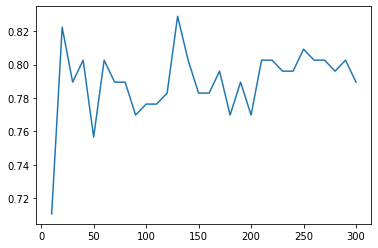

In [33]:

# Maintenant, utilisons les fonctionnalités du réseau convolutif pour RF
# Nous avons besoin d'envoyer nos données d'entrées via l'extracteur de carac vgg16

# featureExtractor=base_model_RF.predict(x_train) # x serait de forme (256*256*3)

# features = featureExtractor.reshape(featureExtractor.shape[0], -1) # featureExtractor est de forme (8,8,512) car après la couche la forme d'image sera block5_pool (MaxPooling2D) (8,8,512)

# X_for_RF = features # Ceci est notre entrée X à RF

# # Foret aléatoire
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
# RF_model = RandomForestClassifier(n_estimators = 100, oob_score = True ,n_jobs = 1,random_state =50)

# # # Entraîner le modèle sur les données d'entraînement
# RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

N = 30
accuracy = []

for i in range(N):

  
    featureExtractor=base_model_RF.predict(x_train) # x serait de forme (256*256*3)

    features = featureExtractor.reshape(featureExtractor.shape[0], -1) # featureExtractor est de forme (8,8,512) car après la couche la forme d'image sera block5_pool (MaxPooling2D) (8,8,512) 

    X_for_RF = features # Ceci est notre entrée X à RF
   
    clf = RandomForestClassifier(n_estimators=(i+1)*10 )
    clf.fit(X_for_RF, y_train)
    X_test_feature =  base_model_RF.predict(x_test)
    X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# Prédisez maintenant à l'aide du modèle RF entraîné.
    prediction_RF = clf.predict(X_test_features)
# Inversez labelEnc transform pour récupérer l'étiquette d'origine (text).
    prediction_RF = le.inverse_transform(prediction_RF)


    accuracy.append(metrics.accuracy_score(test_labels, prediction_RF))
    # accuracy.append(clf.score(testLabels,prediction_RF))
    print((i+1)*10, accuracy[i])

plt.plot([10*(i+1) for i in range(N)], accuracy)
plt.show()



In [34]:
# Maintenant, utilisons les fonctionnalités du réseau convolutif pour RF
# Nous avons besoin d'envoyer nos données d'entrées via l'extracteur de carac vgg16

# feature_extractor=base_model_RF.predict(x_train) # x serait de forme (256*256*3)

# features = feature_extractor.reshape(feature_extractor.shape[0], -1) # feature_extractor est de forme (8,8,512) car après la couche la forme d'image sera block5_pool (MaxPooling2D) (8,8,512)

# X_for_RF = features # Ceci est notre entrée X à RF

# # # Foret aléatoire
# from sklearn.ensemble import RandomForestClassifier
# RF_model = RandomForestClassifier(n_estimators = 100, oob_score = True ,n_jobs = -1,random_state =50)

# # Entraîner le modèle sur les données d'entraînement
# RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding







In [35]:
# # Envoyer les données de test via le même processus d'extraction de caractéristiques
# X_test_feature = base_model_RF.predict(x_test)
# X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# # Prédisez maintenant à l'aide du modèle RF entraîné.
# prediction_RF = RF_model.predict(X_test_features)
# # Inversez le transform pour récupérer l'étiquette d'origine (text).
# prediction_RF = le.inverse_transform(prediction_RF)


In [36]:
# Accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))


Accuracy =  0.7894736842105263


In [37]:
76

76

Matrice de confusion


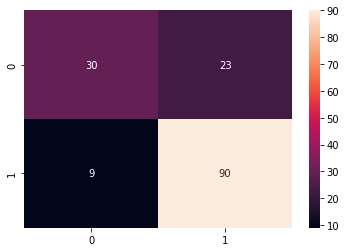

In [38]:

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

cm = confusion_matrix(test_labels, prediction_RF)
print("Matrice de confusion")
sns.heatmap(cm, annot=True)



In [39]:
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# calculate F1 score
y_pred = clf.predict(X_test_features)
f1 = f1_score(y_test, y_pred)

# show the confusion matrix, accuracy, sensitivity, and specificity
# print(cm)
print("accuracy: {:.4f}".format(acc))
print("specificity: {:.4f}".format(specificity))
print("sensitivity: {:.4f}".format(sensitivity))
print("f1_score: {:.4f}".format(f1))

accuracy: 0.7895
specificity: 0.5660
sensitivity: 0.9091
f1_score: 0.8491


In [40]:
print('Classification Report')
target_names = ['benin', 'malin']
print(classification_report(test_labels, prediction_RF))

Classification Report


NameError: ignored

**La courbe ROC**

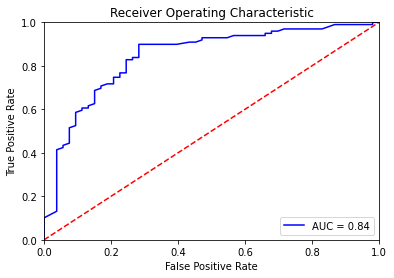

In [41]:
import sklearn.metrics as metrics

probs = clf.predict_proba(X_test_features)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
!pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt
probss = clf.predict_proba(X_test_features)
y_true = y_test # ground truth labels
y_probas = probss # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve( y_true ,y_probas)
plt.show()

## VGG-16 (SVM)  

### SVM 

In [42]:
# -----------
# VGG16 pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------
# Déclaration du modèle VGG16 (sans le top qui est le classifier)
# Déclaration du modèle VGG16 (sans le top qui est le classifier)
base_model_SVM = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))



last = base_model_SVM.layers[-1].output
x = Flatten()(last)
base_model_SVM= Model(base_model_SVM.input, x)


for layer in base_model_SVM.layers[:19]:
    layer.trainable = False 

# Entrainement des derniers layers de classification
for layer in base_model_SVM.layers[19:]:
    layer.trainable = True

layers = [(layer, layer.name, layer.trainable) for layer in base_model_SVM.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_3,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


In [43]:

# compilation du modele
from tensorflow.python.keras.optimizer_v2.adam import Adam 
base_model_SVM.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
print(base_model_SVM.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [44]:
# Nous commençons l'entrainement 
epochs = 25
batch_size = 16
Train = True
# Nous entrainons le modèle 

base_model_SVM.fit(x_train, y_train,
          batch_size=batch_size,
          validation_data=(x_test, y_test),
          epochs=epochs)


Epoch 1/25
41/41 [==============================] - 7s 164ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 2/25
41/41 [==============================] - 6s 154ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 3/25
41/41 [==============================] - 6s 155ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 4/25
41/41 [==============================] - 6s 155ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 5/25
41/41 [==============================] - 6s 153ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 6/25
41/41 [==============================] - 6s 155ms/step - loss: 8.2520 - accuracy: 0.0000e+00 - val_loss: 8.0960 - val_accuracy: 0.0000e+00
Epoch 7/25
41/41 [==============================] - 6s 155ms/step - loss: 8.2520 - accuracy: 0.0000e

In [45]:
# Maintenant, utilisons les fonctionnalités du réseau convolutif pour RF
# Nous avons besoin d'envoyer nos données d'entrées via l'extracteur de carac vgg16

feature_extractor=base_model_SVM.predict(x_train) # x serait de forme (256*256*3)

features = feature_extractor.reshape(feature_extractor.shape[0], -1) # feature_extractor est de forme (8,8,512) car après la couche la forme d'image sera block5_pool (MaxPooling2D) (8,8,512)

X_for_SVM = features # Ceci est notre entrée X à RF

# # Foret aléatoire
from sklearn import svm
SVM_model = svm.SVC(kernel='rbf',gamma=0.001,probability=True)
# Entraîner le modèle sur les données d'entraînement
SVM_model.fit(X_for_SVM, y_train) #For sklearn no one hot encoding







SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [46]:
# Envoyer les données de test via le même processus d'extraction de caractéristiques
X_test_feature = base_model_SVM.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

# Prédisez maintenant à l'aide du modèle RF entraîné.
prediction_SVM = SVM_model.predict(X_test_features)
# Inversez le transform pour récupérer l'étiquette d'origine (text).
prediction_SVM = le.inverse_transform(prediction_SVM)


In [47]:
# Accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVM))


Accuracy =  0.7828947368421053


Matrice de confusion


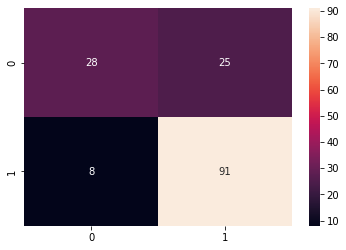

In [48]:

#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix, f1_score

import seaborn as sns
cm = confusion_matrix(test_labels, prediction_SVM)
print("Matrice de confusion")
sns.heatmap(cm, annot=True)



In [49]:
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# calculate F1 score
y_pred = SVM_model.predict(X_test_features)
f1 = f1_score(y_test, y_pred)

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("specificity: {:.4f}".format(specificity))
print("sensitivity: {:.4f}".format(sensitivity))
print("f1_score: {:.4f}".format(f1))

[[28 25]
 [ 8 91]]
acc: 0.7829
specificity: 0.5283
sensitivity: 0.9192
f1_score: 0.8465


In [50]:
print('Classification Report')
target_names = ['benin', 'malin']
print(classification_report(test_labels, prediction_SVM))

Classification Report


NameError: ignored

**La courbe ROC**

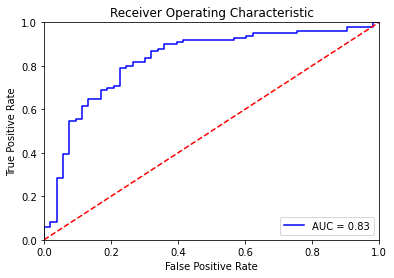

In [52]:
import sklearn.metrics as metrics


probs = SVM_model.predict_proba(X_test_features)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


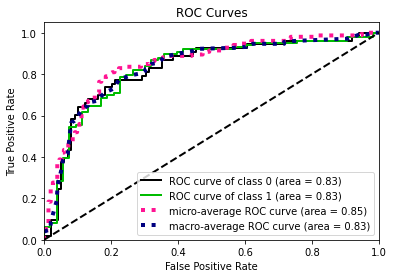

In [53]:
!pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt
probs = SVM_model.predict_proba(X_test_features)
y_true = y_test # ground truth labels
y_probas = probs # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve( y_true ,y_probas)
plt.show()

##EFFI (MLP)

In [54]:
from tensorflow.keras.applications import EfficientNetB0
base_model_effi = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
from tensorflow.keras.layers import BatchNormalization

for layer in base_model_effi.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
# base_model.load_weights(load_pathVGG,by_name=True)

16711680/16705208 [==============================] - 0s 0us/step


In [55]:
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

In [56]:
# EFF MLP
# predict_classes
Y = base_model_effi.output
Y = Flatten()(Y)
Y = Dropout(0.5)(Y)
Y = Dense(128, activation='relu', name='top-fc1')(Y)
Y = Dense(128, activation='relu', name='top-fc2')(Y)
Y = Dense(128, activation='relu', name='top-fc3')(Y)
# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer_effi = Dense(CLASS_NUMBER, activation='softmax', name='softmax')(Y)

In [57]:
# Assemblage du modèle final
net_final_effi = Model(inputs=base_model_effi.input, outputs=output_layer_effi)
# Entrainement des derniers layers de classification
for layer in net_final_effi.layers[:162]:
    layer.trainable = False 

# Entrainement des derniers layers de classification
for layer in net_final_effi.layers[162:]:
    layer.trainable = True

# compilation du modele
net_final_effi.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
print(net_final_effi.summary())

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

## Resnet50V2 (MLP)  

In [58]:

# C pre-entrainé sans le classifier final
# https://github.com/keras-team/keras/issues/4465
# -----------
#  Déclaration du modèle RESNET (sans le top qui est le classifier)

base_model_RS= tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_shape=(IMGSIZE, IMGSIZE, 3))

94674944/94668760 [==============================] - 1s 0us/step


In [59]:
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization

In [60]:
A = base_model_RS.output
A = Flatten()(A)
A = Dropout(0.5)(A)
A = Dense(128, activation='relu', name='top-fc1')(A)
A = Dense(128, activation='relu', name='top-fc2')(A)
A = Dense(128, activation='relu', name='top-fc3')(A)
# output layer: nombre de neurones de sortie = nombre de classe a prédire
output_layer_RS = Dense(CLASS_NUMBER, activation='softmax', name='softmax')(A)

**Model final (Resnet50V2 + MLP )** **& Fine-tuning**

In [61]:
# Assemblage du modèle final
net_final_RS = Model(inputs=base_model_RS.input, outputs=output_layer_RS)

for layer in net_final_RS.layers[:188]:
    layer.trainable = False
    print('Layer ' + layer.name + 'Gelé.')

    
# Entrainement des derniers layers de classification
for layer in net_final_RS.layers[188:]:
    layer.trainable = True
    print('Layer ' + layer.name + 'Non gelé.')



# compilation du modele
net_final_RS.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])


Layer input_5Gelé.
Layer conv1_padGelé.
Layer conv1_convGelé.
Layer pool1_padGelé.
Layer pool1_poolGelé.
Layer conv2_block1_preact_bnGelé.
Layer conv2_block1_preact_reluGelé.
Layer conv2_block1_1_convGelé.
Layer conv2_block1_1_bnGelé.
Layer conv2_block1_1_reluGelé.
Layer conv2_block1_2_padGelé.
Layer conv2_block1_2_convGelé.
Layer conv2_block1_2_bnGelé.
Layer conv2_block1_2_reluGelé.
Layer conv2_block1_0_convGelé.
Layer conv2_block1_3_convGelé.
Layer conv2_block1_outGelé.
Layer conv2_block2_preact_bnGelé.
Layer conv2_block2_preact_reluGelé.
Layer conv2_block2_1_convGelé.
Layer conv2_block2_1_bnGelé.
Layer conv2_block2_1_reluGelé.
Layer conv2_block2_2_padGelé.
Layer conv2_block2_2_convGelé.
Layer conv2_block2_2_bnGelé.
Layer conv2_block2_2_reluGelé.
Layer conv2_block2_3_convGelé.
Layer conv2_block2_outGelé.
Layer conv2_block3_preact_bnGelé.
Layer conv2_block3_preact_reluGelé.
Layer conv2_block3_1_convGelé.
Layer conv2_block3_1_bnGelé.
Layer conv2_block3_1_reluGelé.
Layer conv2_block3_2_

## LE NUMERO DE COUCHE POUR CHAQUE MODELS 

### VGG

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in base_model_VGG.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

###EFFICIENT

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in base_model_effi.layers]
pd.set_option("max_rows",237 
              )
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

###RESNET50v2

In [ ]:
layers = [(layer, layer.name, layer.trainable) for layer in base_model_RS.layers]
pd.set_option("max_rows",190  
              )
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

 # Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
***Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données***

In [62]:
# Génération des STEPS_SIZE (comme nous utilisons des générateurs infinis)
# Ceci est nécessaire pour déterminer à quel moment nous avons parcouru entiérement nos jeu de données
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size 
print(STEP_SIZE_TRAIN)
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size 
print(STEP_SIZE_VALID)
STEP_SIZE_TEST  = test_generator.n  // test_generator.batch_size
print(STEP_SIZE_TEST)


13
5
159


# TRAIN OF ''MODELS'' 

###VGG

In [63]:

    # Entrainement du modèle
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

    
    # Entrainement du modèle
history1 = net_final_VGG.fit_generator(
                    generator=train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [early],
                    epochs = EPOCH)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/80
13/13 [==============================] - 57s 4s/step - loss: 1.6294 - accuracy: 0.6159 - val_loss: 1.0491 - val_accuracy: 0.7312
Epoch 2/80
13/13 [==============================] - 6s 428ms/step - loss: 0.8956 - accuracy: 0.6667 - val_loss: 0.5998 - val_accuracy: 0.7688
Epoch 3/80
13/13 [==============================] - 6s 424ms/step - loss: 0.6575 - accuracy: 0.7633 - val_loss: 0.7200 - val_accuracy: 0.7500
Epoch 4/80
13/13 [==============================] - 6s 424ms/step - loss: 0.5482 - accuracy: 0.7802 - val_loss: 0.6159 - val_accuracy: 0.7875
Epoch 5/80
13/13 [==============================] - 6s 427ms/step - loss: 0.5192 - accuracy: 0.7802 - val_loss: 0.5408 - val_accuracy: 0.8188
Epoch 6/80
13/13 [==============================] - 6s 425ms/step - loss: 0.3948 - accuracy: 0.8285 - val_loss: 0.5704 - val_accuracy: 0.8000
Epoch 7/80
13/13 [==============================] - 6s 426ms/step - loss: 

###EFFICIENT

In [64]:

early1 = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    # Entrainement du modèle
history2 = net_final_effi.fit_generator(
                    generator=train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [early1],
                    epochs = EPOCH)


Epoch 1/80
13/13 [==============================] - 7s 507ms/step - loss: 0.8887 - accuracy: 0.4686 - val_loss: 0.6639 - val_accuracy: 0.6687
Epoch 2/80
13/13 [==============================] - 4s 296ms/step - loss: 0.5497 - accuracy: 0.7440 - val_loss: 0.5954 - val_accuracy: 0.6812
Epoch 3/80
13/13 [==============================] - 4s 293ms/step - loss: 0.4972 - accuracy: 0.7729 - val_loss: 0.6054 - val_accuracy: 0.6687
Epoch 4/80
13/13 [==============================] - 4s 305ms/step - loss: 0.4711 - accuracy: 0.8116 - val_loss: 0.5980 - val_accuracy: 0.6812
Epoch 5/80
13/13 [==============================] - 4s 311ms/step - loss: 0.4246 - accuracy: 0.8237 - val_loss: 0.5952 - val_accuracy: 0.6875
Epoch 6/80
13/13 [==============================] - 4s 307ms/step - loss: 0.3992 - accuracy: 0.8188 - val_loss: 0.5709 - val_accuracy: 0.7188
Epoch 7/80
13/13 [==============================] - 4s 308ms/step - loss: 0.3700 - accuracy: 0.8527 - val_loss: 0.4963 - val_accuracy: 0.7437
Epoch 

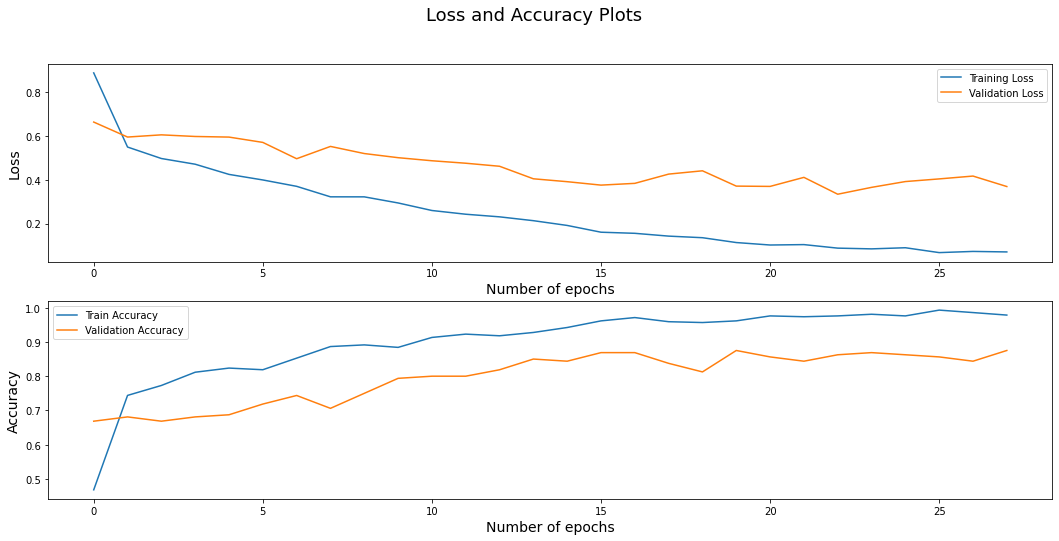

In [65]:
# Les courbes accuracy et Loss
plt.figure(figsize=(18,8)) 
plt.suptitle('Loss and Accuracy Plots', fontsize=18) 
plt.subplot(211)

plt.plot(history2.history['loss'], label='Training Loss') 
plt.plot(history2.history['val_loss'], label='Validation Loss') 
plt.legend() 
plt.xlabel('Number of epochs', fontsize=14) 
plt.ylabel('Loss', fontsize=14) 

plt.subplot(212)

plt.plot(history2.history['accuracy'], label='Train Accuracy') 
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend() 
plt.xlabel('Number of epochs', fontsize=14) 
plt.ylabel('Accuracy', fontsize=14)
plt.show()

###RESNET50V2

In [66]:

early2 = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
    
    # Entrainement du modèle
history3 = net_final_RS.fit_generator(
                    generator=train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    callbacks = [early2],
                    epochs = EPOCH)


Epoch 1/80
13/13 [==============================] - 6s 469ms/step - loss: 0.6225 - accuracy: 0.6522 - val_loss: 0.6662 - val_accuracy: 0.7188
Epoch 2/80
13/13 [==============================] - 4s 305ms/step - loss: 0.5249 - accuracy: 0.7367 - val_loss: 0.7825 - val_accuracy: 0.6500
Epoch 3/80
13/13 [==============================] - 4s 318ms/step - loss: 0.4810 - accuracy: 0.7585 - val_loss: 0.6286 - val_accuracy: 0.6625
Epoch 4/80
13/13 [==============================] - 4s 316ms/step - loss: 0.4595 - accuracy: 0.7899 - val_loss: 0.5604 - val_accuracy: 0.7000
Epoch 5/80
13/13 [==============================] - 4s 318ms/step - loss: 0.4179 - accuracy: 0.8237 - val_loss: 0.4893 - val_accuracy: 0.7312
Epoch 6/80
13/13 [==============================] - 4s 317ms/step - loss: 0.4149 - accuracy: 0.8285 - val_loss: 0.4905 - val_accuracy: 0.7563
Epoch 7/80
13/13 [==============================] - 4s 314ms/step - loss: 0.3591 - accuracy: 0.8527 - val_loss: 0.4662 - val_accuracy: 0.7750
Epoch 

#EVALUATION Des échantillon de validations
***EVALUATION DES IMAGES DE VALIDATION (30 % D'IMAGES DE TRAIN )***

###VGG  


In [ ]:
net_final_VGG.evaluate(valid_generator)[1]

###EFFICIENT

In [ ]:
net_final_effi.evaluate(valid_generator)[1]

###RESNET50V2

In [ ]:
net_final_RS.evaluate(valid_generator)[1]

#Matrice de confusion

###VGG

Confusion Matrix


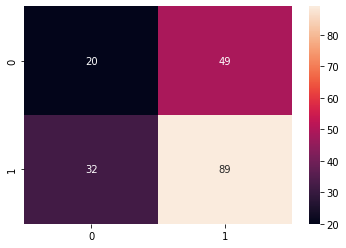

In [67]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, f1_score
import seaborn as sns
probabilities=net_final_VGG.predict_generator(generator=valid_generator)
# probabilities=net_final_EFF.predict_generator(generator=valid_generator)
y_true_vgg = valid_generator.classes
y_pred_vgg = np.argmax(probabilities, axis=1)

print('Confusion Matrix')
cm_vgg= confusion_matrix(valid_generator.classes, y_pred_vgg)
sns.heatmap(cm_vgg, annot=True)

In [68]:

specificity_vgg = cm_vgg[0, 0] / (cm_vgg[0, 0] + cm_vgg[0, 1])
sensitivity_vgg = cm_vgg[1, 1] / (cm_vgg[1, 0] + cm_vgg[1, 1])
# calculate F1 score
f1 = f1_score(y_true_vgg, y_pred_vgg)

# show the confusion matrix, accuracy, sensitivity, and specificity

print("specificity: {:.4f}".format(specificity_vgg))
print("sensitivity: {:.4f}".format(sensitivity_vgg))
print("f1_score: {:.4f}".format(f1))

specificity: 0.2899
sensitivity: 0.7355
f1_score: 0.6873


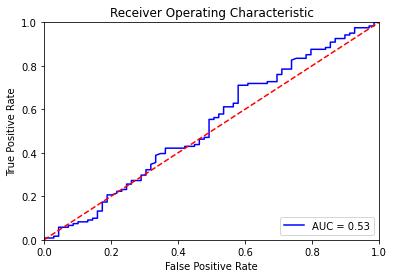

In [69]:
import sklearn.metrics as metrics

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, f1_score
import seaborn as sns
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = net_final_VGG.predict_generator(generator= valid_generator)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(valid_generator.classes, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [70]:
print(net_final_VGG)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


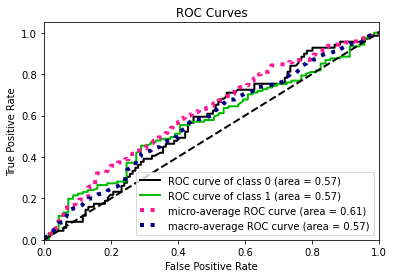

In [71]:
!pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt
probss = net_final_VGG.predict_generator(generator=valid_generator)
y_true = valid_generator.classes # ground truth labels
y_probas = probss # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve( y_true ,y_probas)
plt.show()

##EFFICNET

Confusion Matrix


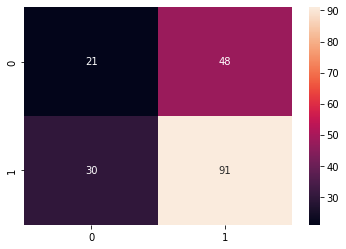

In [72]:

from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, f1_score


probabilities_effi=net_final_effi.predict_generator(generator=valid_generator)
y_trueEFF = valid_generator.classes
y_predEFF = np.argmax(probabilities_effi, axis=1)

print('Confusion Matrix')
cmEFF= confusion_matrix(valid_generator.classes, y_predEFF)
sns.heatmap(cmEFF, annot=True)

In [73]:

specificityEFF = cmEFF[0, 0] / (cmEFF[0, 0] + cmEFF[0, 1])
sensitivityEFF = cmEFF[1, 1] / (cmEFF[1, 0] + cmEFF[1, 1])
# calculate F1 score
f1EFF = f1_score(y_trueEFF, y_predEFF)

# show the confusion matrix, accuracy, sensitivity, and specificity

print("specificity: {:.4f}".format(specificityEFF))
print("sensitivity: {:.4f}".format(sensitivityEFF))
print("f1_score: {:.4f}".format(f1EFF))

specificity: 0.3043
sensitivity: 0.7521
f1_score: 0.7000


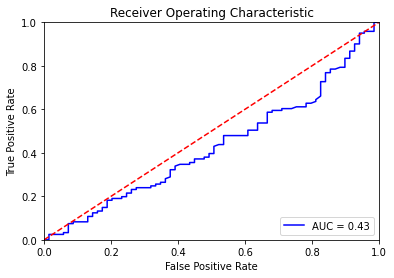

In [74]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = net_final_effi.predict_generator(generator=valid_generator)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(valid_generator.classes, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


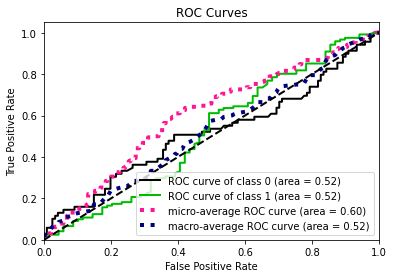

In [75]:
!pip install scikit-plot
import scikitplot as skplt
import matplotlib.pyplot as plt
probss = net_final_effi.predict_generator(generator=valid_generator)
y_true = valid_generator.classes # ground truth labels
y_probas = probss # predicted probabilities generated by sklearn classifier
skplt.metrics.plot_roc_curve( y_true ,y_probas)
plt.show()

###Resnet

Confusion Matrix


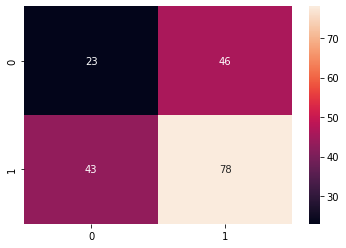

In [76]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, f1_score
import seaborn as sns
probabilities_RS=net_final_RS.predict_generator(generator=valid_generator)
# probabilities=net_final_EFF.predict_generator(generator=valid_generator)
y_true_RS = valid_generator.classes
y_pred_RS = np.argmax(probabilities_RS, axis=1)

print('Confusion Matrix')
cm_rs= confusion_matrix(valid_generator.classes, y_pred_RS)
sns.heatmap(cm_rs, annot=True)

In [77]:

specificity_RS = cm_rs[0, 0] / (cm_rs[0, 0] + cm_rs[0, 1])
sensitivity_RS = cm_rs[1, 1] / (cm_rs[1, 0] + cm_rs[1, 1])
# calculate F1 score
f3 = f1_score(y_true_RS, y_pred_RS)

# show the confusion matrix, accuracy, sensitivity, and specificity

print("specificity: {:.4f}".format(specificity_RS))
print("sensitivity: {:.4f}".format(sensitivity_RS))
print("f1_score: {:.4f}".format(f3))

specificity: 0.3333
sensitivity: 0.6446
f1_score: 0.6367


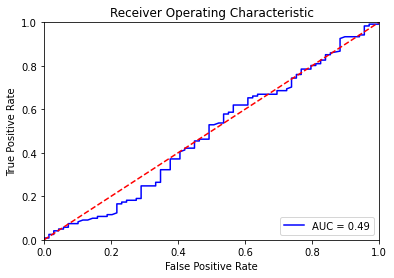

In [78]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = net_final_RS.predict_generator(generator= valid_generator)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(valid_generator.classes, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#TESTER QUELQUES IMAGES DE TESTS 

###VGG

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    img_path=testImages[i]
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_VGG.predict(input_img)
    label="" 
    if score[0][0] > score[0][1]:
      label= "benin"
    else:
      label= "malin"
    
    ax.imshow(image)
    ax.set_title("R :"+testLabels[i]+"\nP: "+label)
   
fig.tight_layout()    
plt.show()

###EFFICENT

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    img_path=testImages[i]
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_effi.predict(input_img)
    label="" 
    if score[0][0] > score[0][1]:
      label= "benin"
    else:
      label= "malin"
    
    ax.imshow(image)
    ax.set_title("R :"+testLabels[i]+"\nP: "+label)
   
fig.tight_layout()    
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=16, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})

for i, ax in enumerate(axes.flat):
    img_path=testImages[i]
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_RS.predict(input_img)
    label="" 
    if score[0][0] > score[0][1]:
      label= "benin"
    else:
      label= "malin"
    
    ax.imshow(image)
    ax.set_title("R :"+testLabels[i]+"\nP: "+label)
   
fig.tight_layout()    
plt.show()

#Interface

In [82]:
!pip install gradio



In [ ]:
class bcolors:
    GREEN = "\033[92m" #GREEN
    RESET = "\033[0m" #RESET COLOR
    RED = "\033[91m" #RED

In [ ]:
 !pip install colorama

In [ ]:
import colorama
from colorama import Fore
from colorama import Style

In [ ]:
colorama.init()

In [ ]:
! pip install ansicolors

In [ ]:
from colors import red, green, blue

print(red('This is red'))
from termcolor import colored

print(colored('hello', 'red'), colored('world', 'green'))


In [ ]:
CRED = '\033[91m'
CEND = '\033[0m'
print(CRED + "Error, does not compute!" + CEND)

In [85]:
import gradio as gr
gr.reset_all()
def efficientnet_b0(img):
  
    image = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_effi.predict(input_img)
    if score[0][0] > score[0][1]:
      labe= "lésion bénigne"
    else:
      labe= "lésion maligne "
    return " Efficientnet_b0  : " + labe + "!"

def VGG_16_MLP(img):
    
    image = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_VGG.predict(input_img)
    labe="" 
    if score[0][0] > score[0][1]:
      labe= "lésion bénigne"
    else:
      labe= "lésion maligne "
    return " VGG-16  : " + labe + "!"

def resnet50v2(img):
    
    image = cv2.resize(img, (224, 224))
    input_img = np.expand_dims(image, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
    score=net_final_RS.predict(input_img)
    labe="" 
    if score[0][0] > score[0][1]:
      labe= "lésion bénigne"
    else:
      labe= "lésion maligne "
    return "Resnet50v2  : " + labe + "!"


def VGG_RF(img):
  testImage = []

  image = cv2.resize(img, (SIZE, SIZE))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  testImage.append(image)
  testImage = np.array(testImage)
  x_test = testImage
  x_test =  x_test / 255.0
  y= x_test[0]
  input_img = np.expand_dims(y, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
  input_img_feature = base_model_RF.predict(input_img)
  input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
  prediction_RF = clf.predict(input_img_features)[0] 
  labe="" 
  if prediction_RF == 0 :
      labe= "lésion bénigne"
  else:
      labe= "lésion maligne "
  return "VGG 16 + Random forest   : " + labe + "!"
 

def VGG_SVM(img):
  testImage = []

  image = cv2.resize(img, (SIZE, SIZE))
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  testImage.append(image)
  testImage = np.array(testImage)
  x_test = testImage
  x_test =  x_test / 255.0
  y= x_test[0]
  input_img = np.expand_dims(y, axis=0) # Développez les dims pour que l'entrée soit (num images, x, y, c)
  input_img_feature = base_model_SVM.predict(input_img)
  input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
  prediction_RF = SVM_model.predict(input_img_features)[0] 
  labe="" 
  if prediction_RF == 0 :
      labe= "lésion bénigne"
  else:
      labe= "lésion maligne "
  return "VGG 16 + SVM   : " + labe + "!"
 


io = gr.Interface([efficientnet_b0,VGG_16_MLP,resnet50v2,VGG_RF, VGG_SVM], "image", "label", interpretation="default")
io.test_launch()
io.launch()


Test launch: efficientnet_b0()... PASSED
Test launch: VGG_16_MLP()... PASSED
Test launch: resnet50v2()... PASSED
Test launch: VGG_RF()... PASSED
Test launch: VGG_SVM()... PASSED
Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 72 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted
Running on External URL: https://12142.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7862/',
 'https://12142.gradio.app')